# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [42]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue.config.json_parser import load_default


from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.stores import load_datasets

### Loading a dataset

Here it is a cylindrical hexagonal mesh.

In [43]:
#h5store = 'before_apoptosis.hf5'
h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
sheet = Sheet('emin', datasets)
sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

In [44]:
settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [45]:
# vp_view(sheet, coords=['z', 'x', 'y'])

In [46]:
sheet.vert_df.sort_values('z').head()

,y,is_active,z,x,rho,old_idx,basal_shift,height,radial_tension
vert,,,,,,,,,
73,-5.987904e+00,0,-10.860857,-4.951674e-15,5.987904,129,-2.878023,8.865927,0.0
0,2.659164e-15,0,-10.860857,5.987904e+00,5.987904,56,-2.878023,8.865927,0.0
37,4.234088e+00,0,-10.860857,-4.234088e+00,5.987904,93,-2.878023,8.865927,0.0
2,4.234088e+00,0,-10.860857,4.234088e+00,5.987904,58,-2.878023,8.865927,0.0
61,-4.234088e+00,0,-10.860857,-4.234088e+00,5.987904,117,-2.878023,8.865927,0.0


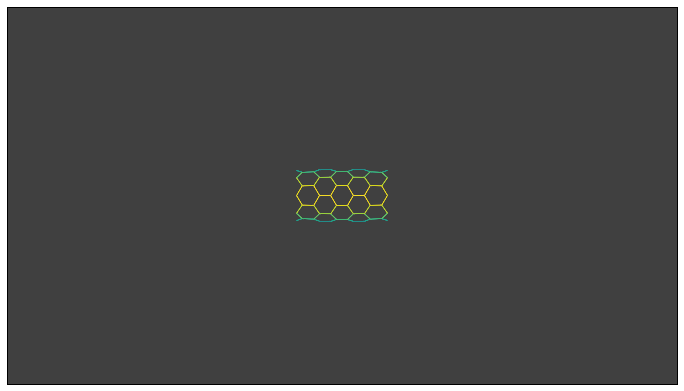

In [47]:
def leg_joint_view(sheet, coords=['z', 'y', 'x']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-45, 45)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((12, 12))
    return fig, ax

fig, ax = leg_joint_view(sheet)


In [63]:
apoptotic_cell = 15#1052

apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Indices of the apoptotic vertices: [24 26 25 29 38 36]


In [57]:
class SheetEvents():
    
    
    def __init__(self, sheet, model, geom):
        self.sheet = sheet
        self.model = model
        self.geom = geom
        
    
    def get_events(self):
        events = {
            'face': {
                'shrink': self.shrink,
                'grow': self.grow,
                'contract': self.contract,
                'type1_at_shorter': self.type1_at_shorter,
                'type3': self.type3,
                'divide': self.type3,
                },
            'vert': {
                'ab_pull': self.ab_pull,
                }
            }
        return events

    def shrink(self, face, *args):
        
        factor = args[0]
        new_vol = self.sheet.specs['face']['prefered_vol'] * factor
        self.sheet.face_df.loc[face, 'prefered_vol'] = new_vol

    def grow(self, face, *args):
        
        return self.shrink(face, *args)
    
    def contract(self, face, *args):
        
        factor = args[0]
        new_contractility = self.sheet.specs['face']['contractility'] * factor
        self.sheet.face_df.loc[face, 'contractility'] = new_contractility
    
    def type1_at_shorter(self, face, *args):
        
        edges = self.sheet.edge_df[self.sheet.edge_df['face']==face]
        shorter = edges.length.argmin()
        type1_transition(self.sheet, shorter)
        self.geom.update_all(self.sheet)
    
    def type3(self, face, *args):
        
        remove_face(sheet, face)
        self.geom.update_all(self.sheet)
    
    def ab_pull(self, vert, *args):
        
        factor = args[0]
        new_tension = self.sheet.specs['vert']['radial_tension'] * factor
        self.sheet.vert_df.loc[vert, 'radial_tension'] = new_tension

        
    def divide(self, face, *args):
        pass

In [58]:
sheet_events = SheetEvents(sheet, model, geom)
events = sheet_events.get_events()

for elem in events:
    print('{} : '.format(elem))
    print('----')
    print('\n'.join([k for k in events[elem]]))
    print('\n')
    

vert : 
----
ab_pull


face : 
----
type1_at_shorter
grow
contract
shrink
type3




In [59]:
from tyssue.core.objects import get_opposite
sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

In [60]:
def apoptosis_time_tables(sheet, apoptotic_cell,
                          events,
                          start_t=0, 
                          shrink_steps=20):
    time_tables = {}
    
    apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
    
    
    n_sides = apoptotic_edges.shape[0]
    duration = shrink_steps + n_sides + 1
    times = range(start_t, start_t + duration)
    shrink_times = range(start_t, start_t + shrink_steps)
    
    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, apoptotic_cell) for t in times],
        names=['t', 'face'])
    time_tables['face'] = pd.DataFrame(index=cell_time_idx,
                                       columns=events['face'].keys())
    
    pref_vols = np.logspace(0, -9, shrink_steps, base=2)
    time_tables['face'].loc[
        start_t: start_t+shrink_steps-1, 'shrink'] = pref_vols
    time_tables['face'].loc[
        start_t + shrink_steps-1: start_t+duration-2, 'type1_at_shorter'] = 1
    time_tables['face'].loc[start_t+duration-1, 'type3'] = 1

    
    apoptotic_verts = apoptotic_edges['srce']
    vert_time_idx = pd.MultiIndex.from_tuples(
        [(t, v) for t in times for v in apoptotic_verts],
         names=['t', 'vert'])
    time_tables['vert'] = pd.DataFrame(index=vert_time_idx,
                                       columns=events['vert'].keys())

    rad_tensions = (np.linspace(0, 1, shrink_steps) *
                    sheet.specs['edge']['line_tension'])

    for v in apoptotic_verts:
        v_idx = pd.MultiIndex.from_tuples(
            [(t, v) for t in shrink_times], names=['t', 'vert'])
        time_tables['vert'].loc[v_idx, 'ab_pull'] = rad_tensions

    return times, time_tables


In [64]:
times, time_tables = apoptosis_time_tables(sheet, apoptotic_cell,
                                           events,
                                           start_t=0, 
                                           shrink_steps=20)

In [65]:
for t in times:
    face_events = time_tables['face'].loc[t]
    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events['face'][event_name](face, event_arg)
            
    vert_events = time_tables['vert'].loc[t]
    for vert, evts in vert_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events['vert'][event_name](vert, event_arg)
    res = solver.find_energy_min(sheet, geom, model, **settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('single_apopto_{:03d}.png'.format(t))
    plt.close(fig)